<a href="https://colab.research.google.com/github/limseo12/Breast-Ultrasound_CNN/blob/main/Breast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# ROOT_DIR, DATA_ROOT_DIR 설정

In [10]:
import os
import shutil
ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT')

In [12]:
CLASSIFICATION_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Classification') #classification

CLASSIFICATION_TRAIN_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train')  #train

In [5]:
if os.path.exists(DATA_ROOT_DIR):
    #if os.path.exists(DATA_ROOT_DIR):: os.path.exists() 함수를 사용하여 DATA_ROOT_DIR 경로가 존재하는지 확인합니다.
    shutil.rmtree(DATA_ROOT_DIR)
    #shutil.rmtree(DATA_ROOT_DIR): shutil.rmtree() 함수를 사용하여 DATA_ROOT_DIR 경로와 해당 디렉토리의 하위 파일 및 디렉토리를 모두 삭제합니다.
    #디렉토리가 비어있지 않은 경우에도 디렉토리와 하위 파일 및 디렉토리를 모두 삭제합니다. 즉, DATA_ROOT_DIR 디렉토리를 완전히 제거합니다.
if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    #if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):: os.path.exists() 함수를 사용하여 CLASSIFICATION_DATA_ROOT_DIR 경로가 존재하는지 확인합니다.
    shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR)
    #shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR): shutil.rmtree() 함수를 사용하여 CLASSIFICATION_DATA_ROOT_DIR 경로와 해당 디렉토리의 하위 파일 및 디렉토리를 모두 삭제합니다.
    #마찬가지로 디렉토리가 비어있지 않은 경우에도 디렉토리와 하위 파일 및 디렉토리를 모두 삭제합니다. CLASSIFICATION_DATA_ROOT_DIR 디렉토리를 완전히 제거합니다.
    #즉, 위의 코드는 DATA_ROOT_DIR와 CLASSIFICATION_DATA_ROOT_DIR 디렉토리가 이미 존재한다면 해당 디렉토리를 삭제하는 역할을 수행합니다.
    #이전에 생성되었던 데이터를 삭제하고 새로운 데이터를 다시 생성하기 위해 해당 디렉토리를 비우는 작업을 수행합니다.

# Google Drive 에서 dataset download

In [6]:
try:
  dataset_path = '/content/gdrive/MyDrive/dataset'

  shutil.copy(os.path.join(dataset_path, 'Dataset_BUSI_with_GT.zip'), '/content')

except Exception as err:
  print(str(err))

In [7]:
import  zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT.zip'), 'r') as target_file:

  target_file.extractall(DATA_ROOT_DIR)

In [8]:
import glob

total_file_list = glob.glob(os.path.join('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT', '*'))

label_name_list = [ file_name.split('/')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True]
#label_name_list = [file_name.split('/')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True]: total_file_list에서 디렉토리 경로만 추출하여 label_name_list에 저장합니다.
#각 경로에서 마지막 디렉토리 이름을 추출하기 위해 split('/')을 사용하고, 추출한 이름에서 양쪽 공백을 제거하기 위해 strip()을 사용합니다.
#os.path.isdir(file_name) == True 조건을 사용하여 디렉토리인지 확인합니다.

if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
  os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

#if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR): os.mkdir(CLASSIFICATION_DATA_ROOT_DIR): CLASSIFICATION_DATA_ROOT_DIR 경로가 존재하지 않으면 해당 디렉토리를 생성합니다.
#분류 작업에 사용될 디렉토리를 생성하는 역할을 합니다.
for label_name in label_name_list:
#for label_name in label_name_list: ...: label_name_list의 각 항목에 대해 반복합니다. 각 레이블 이름에 대해 다음 작업을 수행합니다:
  src_dir_path = os.path.join('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT', label_name)
#src_dir_path = os.path.join(DATA_ROOT_DIR, label_name): 소스 디렉토리 경로를 DATA_ROOT_DIR과 label_name을 결합하여 생성합니다.
  dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR,
                              'train' + '/' +label_name)
#dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'/'+label_name): 대상 디렉토리 경로를 CLASSIFICATION_DATA_ROOT_DIR, 'train', 그리고 label_name을 결합하여 생성합니다.
# 이렇게 함으로써 데이터를 분류하여 저장할 디렉토리 경로를 생성합니다.
  try:
      shutil.copytree(src_dir_path, dst_dir_path)
  except Exception as err:
      print(str(err))
#shutil.copytree(src_dir_path, dst_dir_path): src_dir_path에서 dst_dir_path로 디렉토리와 파일을 복사합니다. 소스 디렉토리의 모든 내용을 대상 디렉토리로 복사합니다.

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
#train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR): CLASSIFICATION_TRAIN_DATA_ROOT_DIR 디렉토리에 있는 디렉토리 목록을 가져와 train_label_name_list에 저장합니다.
for label_name in train_label_name_list:
  print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

#for label_name in train_label_name_list: ...: train_label_name_list의 각 항목에 대해 반복합니다. 각 레이블 이름에 대해 다음 작업을 수행합니다:

#os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name): CLASSIFICATION_TRAIN_DATA_ROOT_DIR과 label_name을 결합하여 디렉토리의 경로를 생성합니다.
#os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)): 해당 디렉토리 안에 있는 파일과 디렉토리의 목록을 가져와 출력합니다. 이는 해당 레이블의 학습 데이터 수를 확인하는 용도로 사용됩니다.
#위의 코드는 데이터 디렉토리의 파일을 분류하여 학습에 사용할 수 있도록 준비하는 작업을 수행합니다. 분류된 데이터는 CLASSIFICATION_TRAIN_DATA_ROOT_DIR 디렉토리에 복사되며, 각 레이블에 대한 학습 데이터의 수를 출력하여 확인합니다.

train label :  malignant  =>  421
train label :  benign  =>  891
train label :  normal  =>  266


# Classification 데이터 생성

In [9]:
if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

In [10]:
#copytree 이용해서 정답 이름/images 디렉토리를 train/정딥 이름 으로 복사

for label_name in label_name_list:

  src_dir_path = os.path.join('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT', label_name)
  dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'/'+label_name)

  try:
    shutil.copytree(src_dir_path, dst_dir_path)
    print(label_name+' copytree is done !!')

  except Exception as err:
    print(str(err))

[Errno 17] File exists: '/content/Classification/train/malignant'
[Errno 17] File exists: '/content/Classification/train/benign'
[Errno 17] File exists: '/content/Classification/train/normal'


In [11]:
train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:

  print('train label : ', label_name, ' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR))))

train label :  malignant  =>  3
train label :  benign  =>  3
train label :  normal  =>  3


In [12]:
import glob
import pandas as pd

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:

  temp_dic = {}

  file_list = glob.glob(CLASSIFICATION_TRAIN_DATA_ROOT_DIR+'/'+label_name+'/*')

  temp_dic[label_name] = file_list

  temp_df = pd.DataFrame(temp_dic)

  image_file_df = temp_df[-temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

  mask_file_df = temp_df[temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

  print('label =', label_name, ' , image = ', len(image_file_df), ' , mask = ', len(mask_file_df))

  for row in range(len(mask_file_df)):

      try:
          os.remove(mask_file_df.loc[row.label_name])
      except Exception as err:
          print(str(err))

label = malignant  , image =  210  , mask =  211
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int' object has no attribute 'label_name'
'int'

Preparing the Data - 학습 데이터 증강 (Data Augmentation)

In [15]:
train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

total_image_data_nums = 0

for label_name in train_label_name_list:

  image_data_nums = len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)))

  print('label = ', label_name, ' , data nums =', image_data_nums)

  total_image_data_nums += image_data_nums

print('total image data nums = ', total_image_data_nums)

label =  malignant  , data nums = 421
label =  benign  , data nums = 891
label =  normal  , data nums = 266
total image data nums =  1578


In [16]:
TOTAL_TRAIN_IMAGE_DATA_NUMS = total_image_data_nums

In [17]:
original_gen = ImageDataGenerator(rescale=1./255) #불러오면서 정규화
original_generator = original_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                                      batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                                      target_size=(224,224), class_mode='sparse')

Found 1578 images belonging to 3 classes.


In [18]:
x_train, y_train = original_generator.next()
print(x_train.shape, y_train.shape)

(1578, 224, 224, 3) (1578,)


# Augmentation Data 생성

In [8]:
AUGMENTATION_COUNT = 4  #원본데이터의 4배 증대

In [19]:
augmentation_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, shear_range=0.1, zoom_range=0.1,
                                      horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

augmentation_generator = augmentation_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                    batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                    target_size=(224, 224), class_mode='sparse')

Found 1578 images belonging to 3 classes.


In [20]:
import numpy as np

print('====================================================')
print('[bofore] ', x_train.shape, y_train.shape)
print('====================================================')

for i in range(AUGMENTATION_COUNT):    # 780개의 전체 데이터에 대해서 AUGMENTATION_COUNT 배 AUGMENTATION 실행

    x_augmented, y_augmented = augmentation_generator.next()

    x_train = np.concatenate( (x_train, x_augmented) )
    y_train = np.concatenate( (y_train, y_augmented) )

print('[after] ', x_train.shape, y_train.shape)
print('====================================================')

[bofore]  (1578, 224, 224, 3) (1578,)
[after]  (7890, 224, 224, 3) (7890,)


# train data random shuffle

In [21]:
s = np.arange(x_train.shape[0])

np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [22]:
SPLIT_RATIO = 0.2    # train : test = 8 : 2

In [23]:
split_num = int(SPLIT_RATIO*(x_train.shape[0]))

x_test = x_train[:split_num]

y_test = y_train[:split_num]

print(x_test.shape, y_test.shape)

(1578, 224, 224, 3) (1578,)


In [24]:
x_train = x_train[split_num:]

y_train = y_train[split_num:]

print(x_train.shape, y_train.shape)

(6312, 224, 224, 3) (6312,)


# 16 개의 데이터와 정답 출력

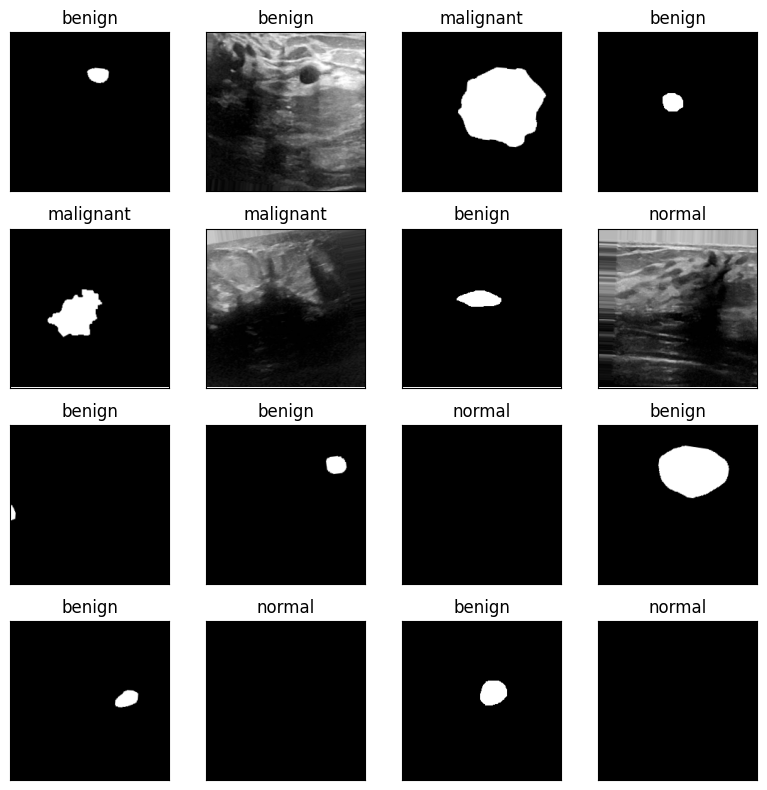

In [25]:
import matplotlib.pyplot as plt

class_dict = {0:'benign', 1:'malignant', 2:'normal'}

plt.figure(figsize=(8,8))

for i in range(16):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[int(y_train[i])]))
    plt.xticks([])
    plt.yticks([])

    plt.imshow(x_train[i])

plt.tight_layout()
plt.show()

IMAGE SHAPE 설정

In [1]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Sequential 모델 구축

In [26]:
from tensorflow.keras.applications.xception import Xception

class_nums = original_generator.num_classes
##Transfer Learning##
pre_trained_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
pre_trained_model.summary()
#####################
model = Sequential()
####################
model.add(pre_trained_model)
############################
model.add(Conv2D(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), kernel_size=(3,3), filters=32, activation='relu'))  #이미지 사이즈
model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

*학습도중 세션이 다운되는 현상이 계속되어 callbacks 함수에 EarlyStopping 외에 check point를 추가한다.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

# EarlyStopping 콜백 정의
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# ModelCheckpoint 콜백 정의
checkpoint = ModelCheckpoint('path/to/save/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

start_time = datetime.now()

hist = model.fit(x_train, y_train, batch_size=32, epochs=50,
                 validation_data=(x_test, y_test), callbacks=[earlystopping, checkpoint])

end_time = datetime.now()

Epoch 1/50


In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
y_pred = model.predict(x_test)

print(y_pred.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()